In [6]:
import numpy as np
'do nothing' if 'np' not in globals() else np.set_printoptions(3, suppress=True);
import matplotlib.pyplot as plt
import cv2

from pdm_lite.team_code.config_nusc import GlobalConfigNusc

DATAPATH = "/home/nupdm/Datasets/nuPDM/routes_training_new/route_route0_routes_training_date_06_18_13_23_49/"

config = GlobalConfigNusc()

ego2lidar = config.ego2lidar
lidar2ego = np.linalg.inv(ego2lidar)

print("Ego to LiDAR transformation matrix:")
print(ego2lidar)
print("LiDAR to Ego transformation matrix:")
print(lidar2ego)

Ego to LiDAR transformation matrix:
[[ 0.   -1.    0.    0.  ]
 [ 1.    0.    0.    0.  ]
 [ 0.    0.    1.   -1.85]
 [ 0.    0.    0.    1.  ]]
LiDAR to Ego transformation matrix:
[[ 0.    1.    0.    0.  ]
 [-1.    0.   -0.   -0.  ]
 [ 0.    0.    1.    1.85]
 [ 0.    0.    0.    1.  ]]


# LIDAR COORDINATES

Pointcloud shape: (31645, 4)
Min Z: -2.0414843559265137, Max Z: 14.346515655517578


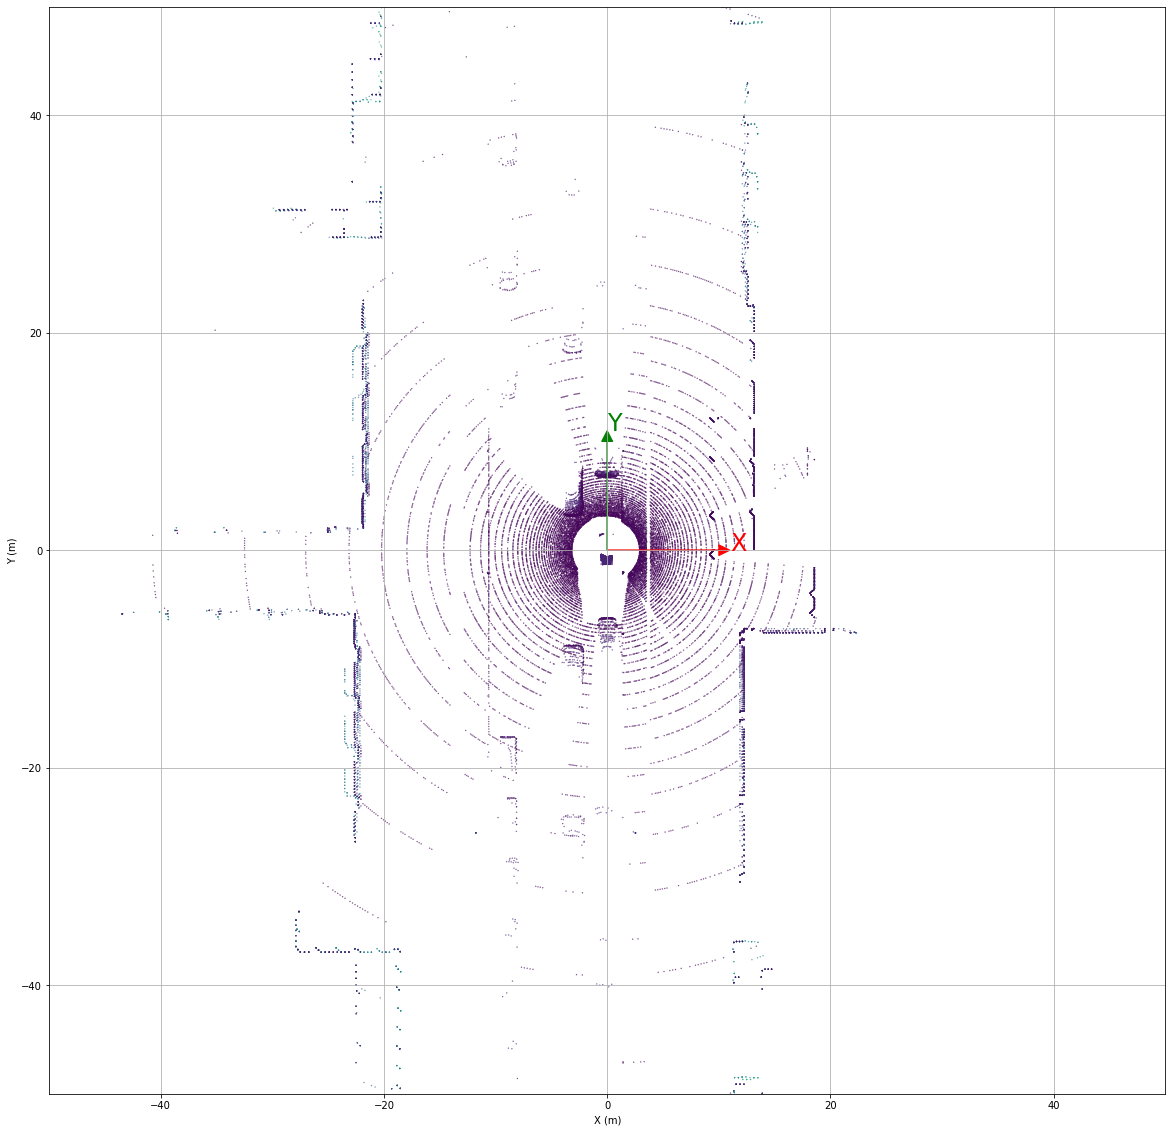

In [2]:
# load pointcloud
ITEM = "0004"
LIDAR_PATH = DATAPATH + "/points/" + ITEM + ".bin"

pointcloud = np.fromfile(LIDAR_PATH, dtype=np.float32).reshape(-1, 4)
print(f"Pointcloud shape: {pointcloud.shape}")

# convert all pointcloud to ego frame
# pointcloud[:, :3] = np.dot(lidar2ego[:3, :3], pointcloud[:, :3].T).T + lidar2ego[:3, 3]

# visualize pointcloud
plt.figure(figsize=(20, 20))
plt.scatter(pointcloud[:, 0], pointcloud[:, 1], c=pointcloud[:, 2], s=0.1, cmap='viridis')
plt.grid()
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.xlim(-50, 50)
plt.ylim(-50, 50)

# PRINT MIN Z AND MAX Z
print(f"Min Z: {np.min(pointcloud[:, 2])}, Max Z: {np.max(pointcloud[:, 2])}")

# draw a point in 5, 3
# plt.scatter(5, 3, c='red', s=100, label='Point (5, 3)')

# draw arrow following x axis
plt.arrow(0, 0, 10, 0, head_width=1, head_length=1, fc='red', ec='red', label='X Axis')
# draw x next to it
plt.text(11, 0, 'X', fontsize=24, color='red')
plt.arrow(0, 0, 0, 10, head_width=1, head_length=1, fc='green', ec='green', label='Y Axis')
# draw draw y next to it
plt.text(0, 11, 'Y', fontsize=24, color='green')

plt.show()

# EGO COORDINATES

Pointcloud shape: (31645, 4)
Min Z after transformation: -0.19148436188697815, Max Z after transformation: 16.196516036987305


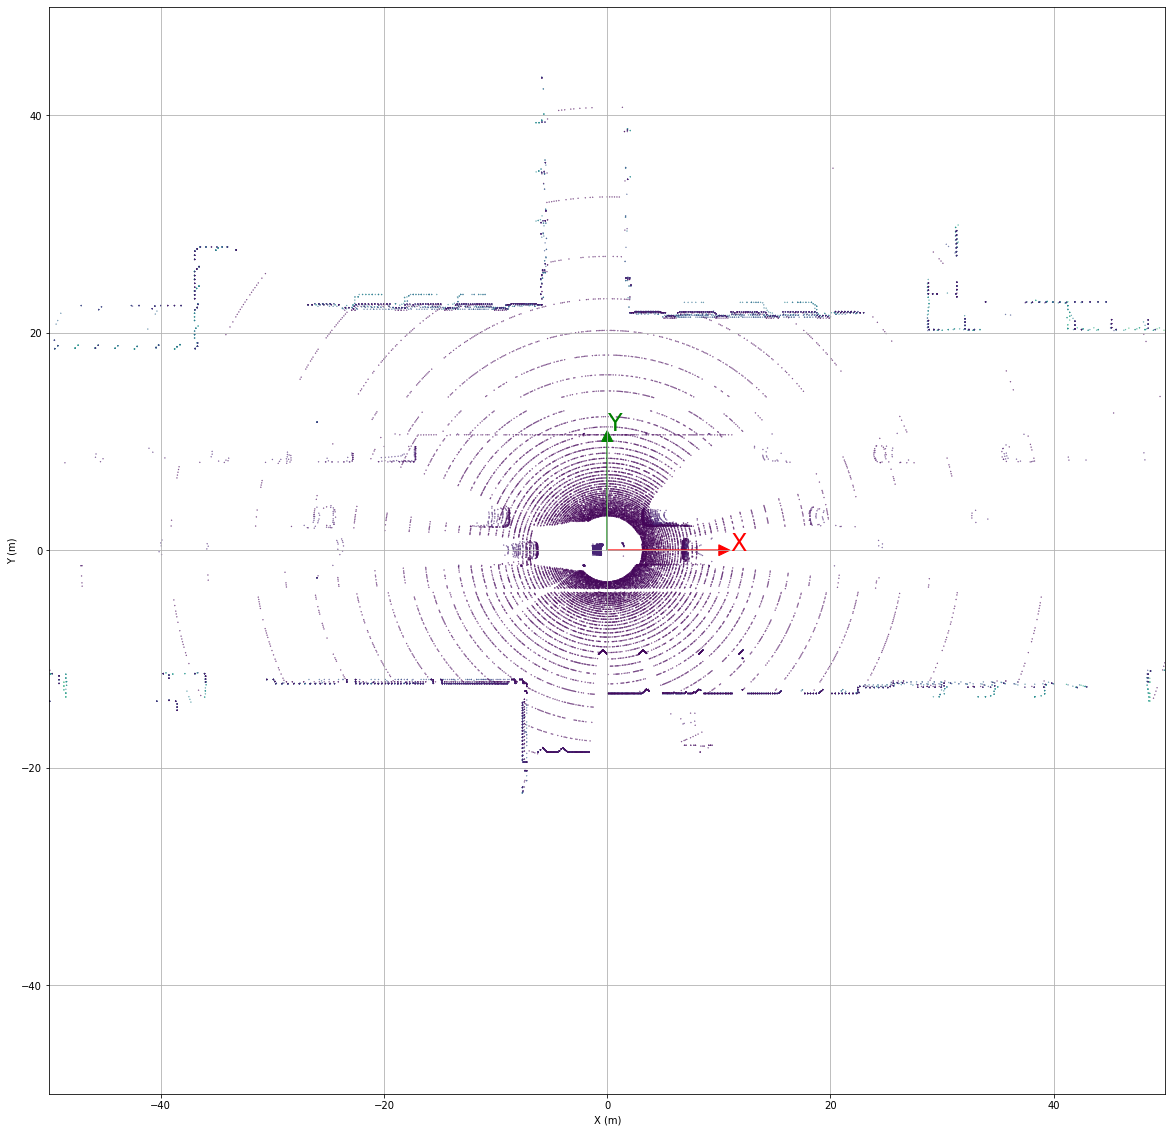

In [3]:
# load pointcloud
ITEM = "0004"
LIDAR_PATH = DATAPATH + "/points/" + ITEM + ".bin"

pointcloud = np.fromfile(LIDAR_PATH, dtype=np.float32).reshape(-1, 4)
print(f"Pointcloud shape: {pointcloud.shape}")

# convert all pointcloud to ego frame
pointcloud[:, :3] = np.dot(lidar2ego[:3, :3], pointcloud[:, :3].T).T + lidar2ego[:3, 3]

# print max and min z
print(f"Min Z after transformation: {np.min(pointcloud[:, 2])}, Max Z after transformation: {np.max(pointcloud[:, 2])}")

# visualize pointcloud
plt.figure(figsize=(20, 20))
plt.scatter(pointcloud[:, 0], pointcloud[:, 1], c=pointcloud[:, 2], s=0.1, cmap='viridis')
plt.grid()
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.xlim(-50, 50)
plt.ylim(-50, 50)

# draw a point in 5, 3
# plt.scatter(5, 3, c='red', s=100, label='Point (5, 3)')

# draw arrow following x axis
plt.arrow(0, 0, 10, 0, head_width=1, head_length=1, fc='red', ec='red', label='X Axis')
# draw x next to it
plt.text(11, 0, 'X', fontsize=24, color='red')
plt.arrow(0, 0, 0, 10, head_width=1, head_length=1, fc='green', ec='green', label='Y Axis')
# draw draw y next to it
plt.text(0, 11, 'Y', fontsize=24, color='green')

plt.show()

Could not load camera image from /home/nupdm/Datasets/nuPDM/routes_training_new/route_route0_routes_training_date_06_18_13_23_49//CAM_FRONT/0004.jpg
Pointcloud shape: (31645, 4)


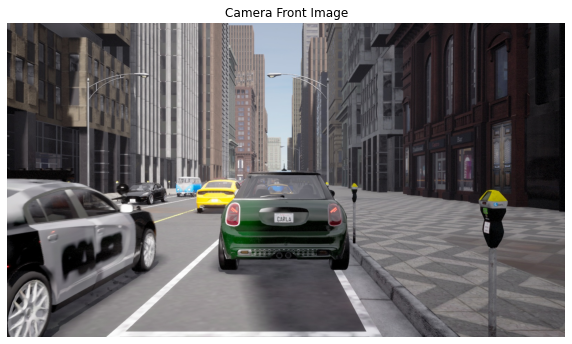

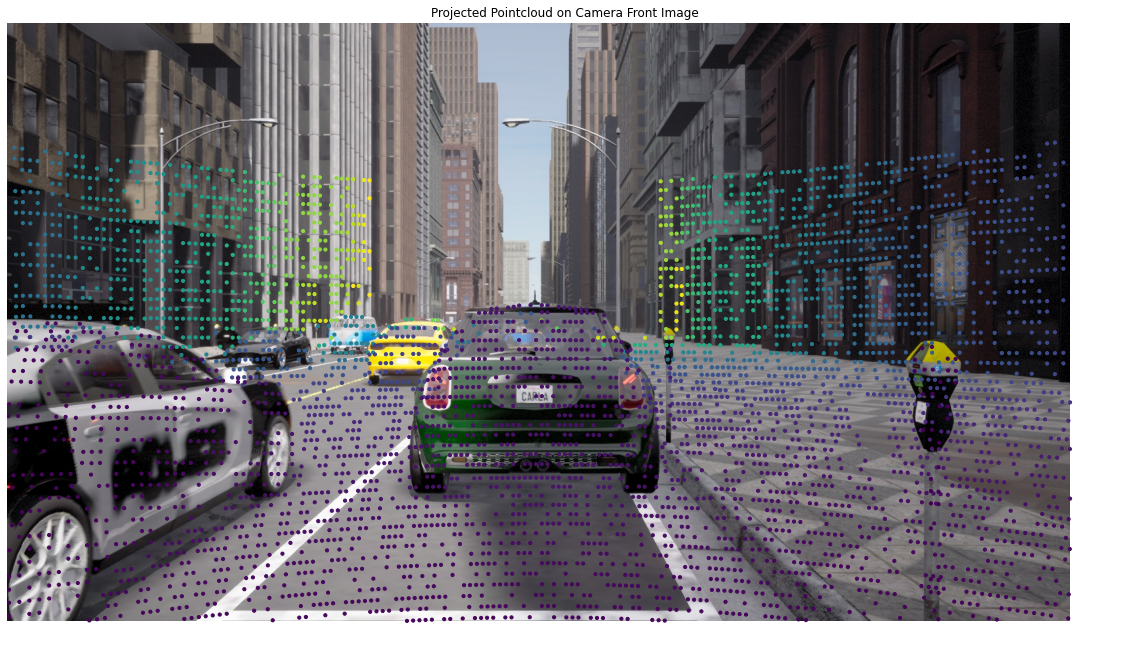

In [4]:
CAM_FRONT_PATH = DATAPATH + "/CAM_FRONT/" + ITEM + ".jpg"

# visualize camera image
cam_image = cv2.imread(CAM_FRONT_PATH)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.title("Camera Front Image")
plt.axis('off')
print(f"Could not load camera image from {CAM_FRONT_PATH}")

# project pointcloud to image

pointcloud = np.fromfile(LIDAR_PATH, dtype=np.float32).reshape(-1, 4)
pointcloud = pointcloud[:, :3]  # Remove intensity channel if present
# add homogeneus
pointcloud = np.hstack((pointcloud, np.ones((pointcloud.shape[0], 1))))  # Add a column of ones for homogeneous coordinates
print(f"Pointcloud shape: {pointcloud.shape}")

lidar2cam_front = config.ego2camera_front @ lidar2ego
lidar_data_front = np.dot(lidar2cam_front, pointcloud.T).T
lidar_data_front = lidar_data_front[lidar_data_front[:, 2] > 0] # Filter points with z < 0
lidar_data_front = np.dot(config.camera_front_K, lidar_data_front.T).T
lidar_data_front[:,0] /= lidar_data_front[:,2]
lidar_data_front[:,1] /= lidar_data_front[:,2]

# Filter points within image bounds
lidar_data_front = lidar_data_front[
    (lidar_data_front[:, 0] >= 0) & (lidar_data_front[:, 0] < 1600) &
    (lidar_data_front[:, 1] >= 0) & (lidar_data_front[:, 1] < 900)
]

# Draw points on the camera image
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.scatter(lidar_data_front[:, 0], lidar_data_front[:, 1], c=lidar_data_front[:, 2], s=10, cmap='viridis', alpha=1)
plt.title("Projected Pointcloud on Camera Front Image")
plt.axis('off')
plt.show()